# Remove bot-or-not noises

### Used files
- bot_or_not_without_info
- sybilscar_results

### Summary:
1. load necessary data
2. Apply logic to add new column "is_noisy"
3. save new bot_or_not_without_noises

### 1. Load necessary data

In [1]:
import polars as pl
import os
pl.Config.set_fmt_str_lengths(400)

polars.config.Config

In [2]:
DATA_PATH = os.getenv("DATA_PATH", "")

In [3]:
bot_or_not = pl.read_parquet(f"{DATA_PATH}/interim/bot_or_not_without_info.parquet")
bot_or_not


fid,bot
i64,bool
446097,false
3,false
8,false
12,false
2,false
…,…
327500,true
428200,true
469138,false


In [4]:
sybilscar_result = pl.read_parquet(f"{DATA_PATH}/../farcaster-social-graph-api/farcaster_social_graph_api/data/sybil_scar_results.parquet")
sybilscar_result

fid_index,posterior,fid
i64,f64,i64
198306,0.0,362936
47055,0.0,690195
326843,0.0,551357
120189,0.0,429013
297387,0.344896,818125
…,…,…
100725,1.0,466914
16259,0.7,863574
128403,1.0,720296


### 2. Apply logic to add new column "is_noisy"

For now, we are considering a sample noisy if sybil scar result (threshold p > 0.5) is different than bot_or_not


In [5]:
df = bot_or_not.join(sybilscar_result,on="fid",coalesce=True,how="left")
df

fid,bot,fid_index,posterior
i64,bool,i64,f64
446097,false,163975,1.0
3,false,8129,1.0
8,false,255872,1.0
12,false,43493,1.0
2,false,248340,1.0
…,…,…,…
327500,true,169966,0.0
428200,true,72388,0.0
469138,false,105841,0.0


In [6]:
# Check that there are indexes in bot_or_not that are outside the sybilscar result
df.filter(pl.col("posterior").is_null())

fid,bot,fid_index,posterior
i64,bool,i64,f64
2348,false,null,null
12144,false,null,null
12775,false,null,null
191322,false,null,null
194515,false,null,null
…,…,…,…
854040,false,null,null
854041,false,null,null
854043,false,null,null


In [19]:
df = df.with_columns([
    pl.when(pl.col("posterior").is_null())
    .then(pl.col("bot"))
    .otherwise(pl.col("bot") != (pl.col("posterior") > 0.5 ))
    .alias("is_noisy")
])

df

fid,bot,fid_index,posterior,is_noisy
i64,bool,i64,f64,bool
446097,false,163975,1.0,true
3,false,8129,1.0,true
8,false,255872,1.0,true
12,false,43493,1.0,true
2,false,248340,1.0,true
…,…,…,…,…
327500,true,169966,0.0,true
428200,true,72388,0.0,true
469138,false,105841,0.0,false


In [22]:
df.filter(pl.col("bot").is_in([True]))["is_noisy"].sum()

3421

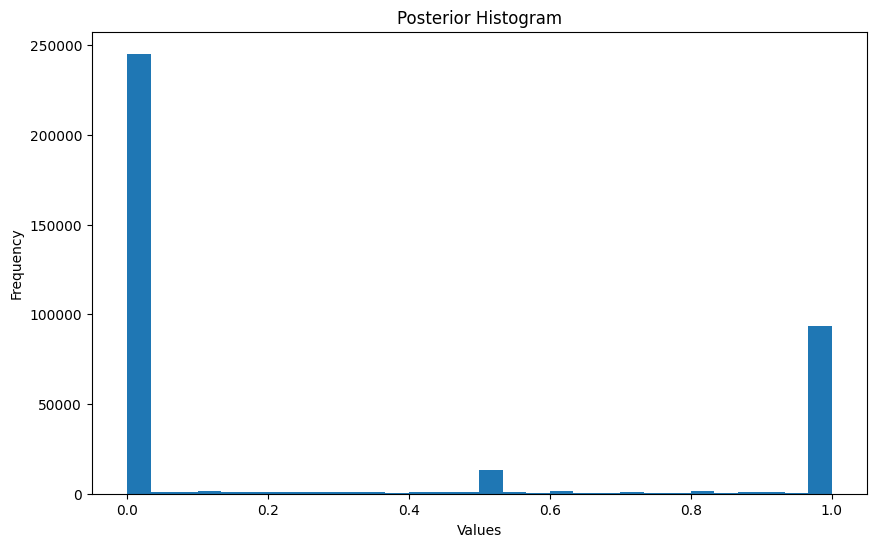

In [24]:
import matplotlib.pyplot as plt

# Single histogram
plt.figure(figsize=(10, 6))
plt.hist(sybilscar_result["posterior"], bins=30)
plt.title('Posterior Histogram')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()